# Validation of parallax correction on synthetic data.

In this notebook we will build a synthetic dataset and apply parallax effect to it using raytracing.
Then this data will be deconvoluted with different methods.
Finally we will compare the calibration of:
* the initial synthetic dataset,
* the parallax blurred dataset,
* the deconvoluted dataset,
* assess the parallax correction implemented in pyFAI without deconvolution.

In this tutorial, we will use `Titan` detector (2048x2048 pixels of 60µm each) with 1mm Si sensor at 20 keV.
The sample is a perfect LaB6 placed just 7 cm in front of the detector in orthogonal geometry.

Attenion, the `Titan` detector has a Gadox phosphor, the usage of Silicon is just for demonstration of the parallax. The warnings about the sensor are expected.

In [1]:
%matplotlib inline
# %matplotlib widget
# use `widget` instead of `inline` for better user-experience. `inline` allows to store plots into notebooks.

In [29]:
import time
start_time = time.perf_counter()
import json
import numpy
from matplotlib.pyplot import subplots
from scipy.sparse import csr_matrix, csc_matrix, linalg
import h5py
import fabio
import pyFAI
import pyFAI.units
import pyFAI.detectors
from pyFAI.calibrant import get_calibrant
from pyFAI.detectors.sensors import Si_MATERIAL
from pyFAI.gui import jupyter
import hdf5plugin

from pyFAI.ext.parallax_raytracing import Raytracing
numpy.random.seed(0)

ai = pyFAI.load({"dist": 7e-2,
                 "poni1": 6e-2,
                 "poni2": 6e-2,
                 "detector": "Titan", 
                 "detector_config":{"sensor":{"material": "Si", 
                                              "thickness":1e-3}}})
energy = ai.energy = 20  # keV
thickness = ai.detector.sensor.thickness
print(ai)

Detector Titan 2k x 2k	 PixelSize= 60µm, 60µm	 BottomRight (3)	 Si,1mm
Wavelength= 0.619921 Å	Parallax: off
SampleDetDist= 7.000000e-02 m	PONI= 6.000000e-02, 6.000000e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 70.000 mm	Center: x=1000.000, y=1000.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° λ= 0.620Å


## Absorption coefficient at 20 keV

In [8]:
print(f"µ = {Si_MATERIAL.mu(energy, unit="cm"):.1f} cm^-1 "
      f"hence absorption efficiency for 450µm: {100*Si_MATERIAL.absorbance(energy, thickness):.1f} %")
mu = Si_MATERIAL.mu(energy, unit="m")

µ = 10.4 cm^-1 hence absorption efficiency for 450µm: 64.6 %


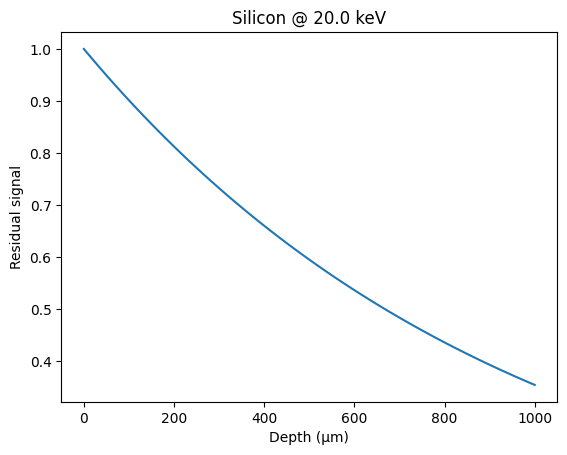

In [9]:
depth = numpy.linspace(0, 1000, 100)
res = [1-Si_MATERIAL.absorbance(energy, d, "µm") for d in depth]
fig, ax = subplots()
ax.plot(depth, res, "-")
ax.set_xlabel("Depth (µm)")
ax.set_ylabel("Residual signal")
ax.set_title(f"Silicon @ {energy:.1f} keV");

This is consistent with:
[henke.lbl.gov](http://henke.lbl.gov/optical_constants/filter2.html) or 
[web-docs.gsi.de](https://web-docs.gsi.de/~stoe_exp/web_programs/x_ray_absorption/index.php)

Let's buid some fake diffraction data: LaB6 is providing nice rings:

In [10]:
fwhm = 0.05
LaB6 = get_calibrant("LaB6")
LaB6.wavelength = ai.wavelength
xrpd = LaB6.fake_xrpdp(1000, (0,55), resolution=fwhm)
img = numpy.random.poisson(LaB6.fake_calibration_image(ai, resolution=fwhm, Imax=1e6))

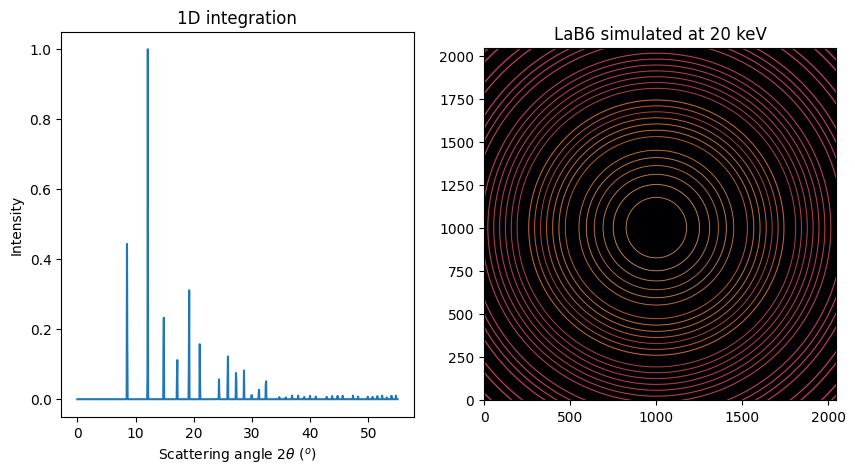

In [11]:
fig, ax = subplots(1, 2, figsize=(10,5))
jupyter.plot1d(xrpd, ax=ax[0])
jupyter.display(img, ax=ax[1])
ax[1].set_title(f"LaB6 simulated at {energy} keV");

Now we can model the parallax in the detector using raytracing.

## Modeling of the detector:

The detector is represented as a 2D array of voxels.

In [12]:
detector= ai.detector
print(detector)

vox = detector.pixel2 # this is not a typo
voy = detector.pixel1 # x <--> axis 2
voz = thickness

print(f"Voxel size: (x:{vox}, y:{voy}, z:{voz})")
print(f"Maximum incidence angle : {numpy.rad2deg(numpy.arcsin(ai.sin_incidence(d1=None, d2=None))).max():.1f}°")

Detector Titan 2k x 2k	 PixelSize= 60µm, 60µm	 BottomRight (3)	 Si,1mm
Voxel size: (x:6e-05, y:6e-05, z:0.001)
Maximum incidence angle : 51.8°


The intensity grabbed in this voxel is the triple integral of the absorbed signal coming from this pixel or from the neighboring ones.

There are 3 ways to perform this intergral:
* Volumetric analytic integral. Looks feasible with a change of variable in the depth
* Slice per slice, the remaining intensity depand on the incidence angle + pixel splitting between neighbooring pixels
* raytracing: the decay can be solved analytically for each ray, one has to throw many ray to average out the signal.

For sake of simplicity, this integral will be calculated numerically using this raytracing algorithm.
http://www.cse.yorku.ca/~amana/research/grid.pdf

Knowing the input position for a X-ray on the detector and its propagation vector, this algorithm allows us to calculate  the length of the path in all voxel it crosses in a fairly efficient way.

To speed up the calculation, we will use a few tricks:
* One ray never crosses more than 16 pixels, which is reasonable considering the incidance angle 
* we use numba to speed-up the calculation of loops in python
* We will allocate the needed memory by chuncks of 1 million elements


In [14]:
ai.enable_parallax(True)
rt = Raytracing(ai)
print("Performance of raytracing in Cython:")
%time pre_csr = rt.calc_csr(4)

Performance of raytracing in Cython:


CPU times: user 27 s, sys: 1.17 s, total: 28.1 s
Wall time: 1.09 s


In [15]:
rt = Raytracing(ai, buffer_size=64)
print("Performance of raytracing in Cython:")
%time pre_csr = rt.calc_csr(4)

Performance of raytracing in Cython:
CPU times: user 42.6 s, sys: 1.32 s, total: 43.9 s
Wall time: 1.62 s


## Validation of the CSR matrix obtained:

For this we will build a simple 2D image with one pixel in a regular grid and calculate the effect of the transformation calculated previously on it. 

In [17]:
%time csr = csr_matrix(rt.calc_csr(32)) # 1024 rays per pixel!

CPU times: user 32min 41s, sys: 2.5 s, total: 32min 43s
Wall time: 44.5 s


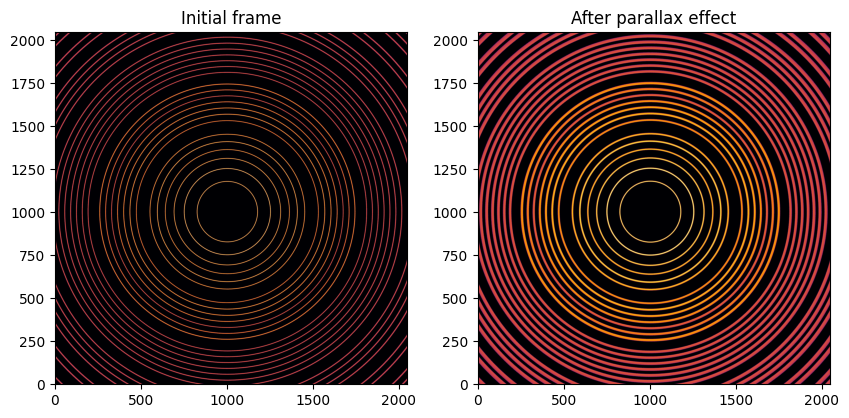

In [22]:
sparse = csr.T
img_blurred = sparse.dot(img.ravel()).reshape(img.shape)
img_blurred = numpy.random.poisson(img_blurred)
fig, ax = subplots(1,2, figsize=(10,5))
jupyter.display(img, ax=ax[0])
jupyter.display(img_blurred, ax=ax[1])
ax[0].set_title("Initial frame")
ax[1].set_title("After parallax effect");

In [32]:
with h5py.File("parallax_frames.h5", "w") as h:
    for k,v in ai.get_config().items():
        try:
            h[f"poni/{k}"] = v
        except TypeError:
            h[f"poni/{k}"] = json.dumps(v)
    h["sample"] = "LaB6"
    h.create_dataset("no_parallax", data=img, compression=hdf5plugin.Bitshuffle())
    h.create_dataset("parallax", data=img_blurred, compression=hdf5plugin.Bitshuffle())

In [33]:
from pyFAI.geometryRefinement import GeometryRefinement

In [38]:
gr = GeometryRefinement([[825, 980, 0], [1063, 1163, 0], [833, 1054, 0], [1005, 1174, 0], [824, 1005, 0]],
                        LaB6, 0.1, rot1=0, rot2=0, rot3=0, detector=detector, wavelength=ai.wavelength)
gr.refine3()
gr

Detector Titan 2k x 2k	 PixelSize= 60µm, 60µm	 BottomRight (3)	 Si,1mm
Wavelength= 0.604732 Å	Parallax: off
SampleDetDist= 7.223741e-02 m	PONI= 5.961348e-02, 5.988341e-02 m	rot1=-0.000124  rot2=0.006049  rot3=-0.000000 rad
DirectBeamDist= 72.239 mm	Center: x=998.206, y=1000.841 pix	Tilt= 0.347° tiltPlanRotation= 88.825° λ= 0.605Å

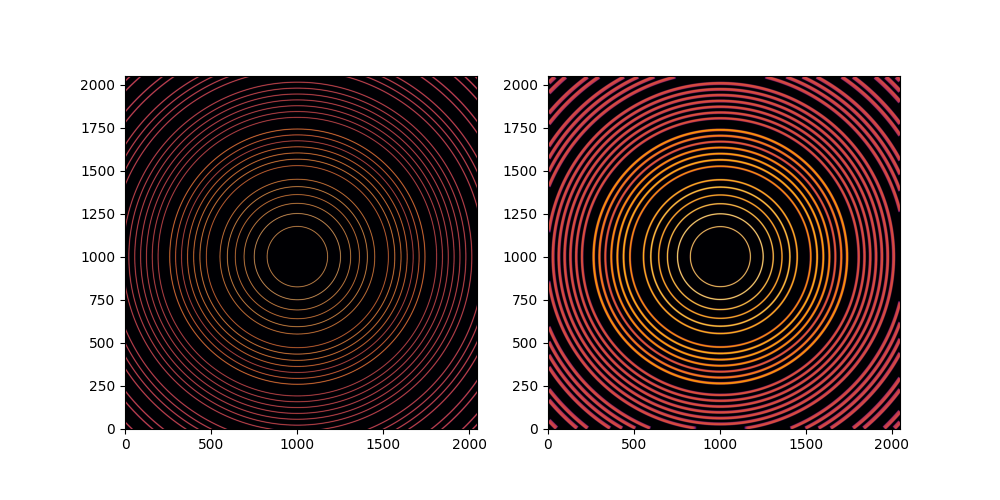

In [37]:
img_blurred = csr.dot(img.ravel()).reshape(img.shape)
fig, ax = subplots(1,2, figsize=(10,5))
jupyter.display(img,ax=ax[0])
jupyter.display(img_blurred,ax=ax[1]);
numpy.save("LaB6_20keV_parallax.npy", img_blurred)

In [ ]:
dummy_image = numpy.ones(mask.shape, dtype="float32")
dummy_image[::5,::5] = 10

dummy_blurred = csr.T.dot(dummy_image.ravel()).reshape(mask.shape)
fix, ax = subplots(2,2, figsize=(8,8))
ax[0,0].imshow(dummy_image)
ax[0,0].set_title("Original image")
ax[0,1].imshow(dummy_blurred)
ax[0,1].set_title("Convolved image (i.e. blurred)")
ax[1,1].imshow(csr.dot(dummy_blurred.ravel()).reshape(mask.shape));
ax[1,1].set_title("Retro-projected of the blurred")
ax[0,0].set_xlim(964,981)
ax[0,0].set_ylim(0,16)
ax[0,1].set_xlim(964,981)
ax[0,1].set_ylim(0,16)
ax[1,1].set_xlim(964,981)
ax[1,1].set_ylim(0,16);

# Least squares refinement of the pseudo-inverse

In [ ]:
blured = dummy_blurred.ravel()

# Invert this matrix: see https://arxiv.org/abs/1006.0758

%time res = linalg.lsmr(csr.T, blured)
restored = res[0].reshape(mask.shape)

fix, ax = subplots(2,2, figsize=(8,8))
ax[0,0].imshow(dummy_image)
ax[0,0].set_title("Original image")
ax[0,1].imshow(dummy_blurred)
ax[0,1].set_title("Convolved image (i.e. blurred)")
ax[1,1].imshow(csr.dot(dummy_blurred.ravel()).reshape(mask.shape));
ax[1,1].set_title("Retro-projected of the blurred")
ax[0,0].set_xlim(964,981)
ax[0,0].set_ylim(0,16)
ax[0,1].set_xlim(964,981)
ax[0,1].set_ylim(0,16)
ax[1,1].set_xlim(964,981)
ax[1,1].set_ylim(0,16);
ax[1,0].imshow(restored)
ax[1,0].set_title("Restored LSMR")
ax[1,0].set_xlim(964,981)
ax[1,0].set_ylim(0,16);

# Pseudo inverse with positivitiy constrain and poissonian noise (MLEM)

The MLEM algorithm was initially developed within the framework of reconstruction of
images in emission tomography [Shepp and Vardi, 1982], [Vardi et al., 1985], [Lange and
Carson, 1984]. Nowadays, this algorithm is employed in numerous tomographic reconstruction
problems and often associated to regularization techniques. It is based on the iterative
maximization of the log-likelihood function.

In [ ]:
def iterMLEM_scipy(F, M, R):
    "Implement one step of MLEM"
    #res = F * (R.T.dot(M))/R.dot(F)# / M.sum(axis=-1)
    norm = 1/R.T.dot(numpy.ones_like(F)) 
    cor = R.T.dot(M/R.dot(F))
    res = norm * F * cor
    res[numpy.isnan(res)] = 1.0
    return res

def deconv_MLEM(csr, data, thres=0.2, maxiter=1000):
    R = csr.T
    msk = data<0
    img = data.astype("float32")
    img[msk] = 0.0 # set masked values to 0, negative values could induce errors
    M = img.ravel()
    #F0 = numpy.random.random(data.size)#M#
    F0 = R.T.dot(M)
    F1 = iterMLEM_scipy(F0, M, R)
    delta = abs(F1-F0).max()
    for i in range(maxiter):
        if delta<thres:
            break
        F2 = iterMLEM_scipy(F1, M, R)
        delta = abs(F1-F2).max()
        if i%100==0:
            print(i, delta)
        F1 = F2
        i+=1
    print(i, delta)
    return F2.reshape(img.shape)

%time res = deconv_MLEM(csr, dummy_blurred, 1e-4)

In [ ]:
fix, ax = subplots(2,2, figsize=(8,8))
ax[0,0].imshow(dummy_image)
ax[0,1].imshow(dummy_blurred)
ax[1,1].imshow(csr.dot(dummy_blurred.ravel()).reshape(mask.shape))
ax[0,0].set_xlim(964,981)
ax[0,0].set_ylim(0,16)
ax[0,0].set_title("Original image")
ax[0,1].set_xlim(964,981)
ax[0,1].set_ylim(0,16)
ax[0,1].set_title("Convolved image (i.e. blurred)")
ax[1,1].set_xlim(964,981)
ax[1,1].set_ylim(0,16)
ax[1,1].set_title("Retro-projected of the blurred")
# ax[1,0].set_title("Corrected image");
ax[1,0].imshow(res)
ax[1,0].set_xlim(964,981)
ax[1,0].set_ylim(0,16)
ax[1,0].set_title("Corrected image: MLEM");

## Performance measurements ... multi-threaded

In [ ]:
perfs = {}
for i in range(8):
    j = 1<<i
    print(f"{j:3d} threads: ", end="")
    perfs[(j, cythick.buffer_size)] = %timeit -o -n1 -r1 cythick.calc_csr(8, threads=j)

In [ ]:
buf = 32
cythick = CythonThickDetector(172e-6,172e-6, thickness=thickness, mu=mu, dist=dist, poni1=poni1, poni2=poni2, mask=mask, buffer_size=buf)
cythick.calc_csr(1)
for i in range(8):
    j = 1<<i
    print(f"{j:3d} threads: ", end="")
    perfs[(j,cythick.buffer_size)] = %timeit -o -n1 -r1 cythick.calc_csr(8, threads=j)

In [ ]:

    
fig, ax = subplots(1,2, figsize=(12,6))
t = [i[0] for i in perfs if i[1] == 16]
y16 = [v.best for k,v in perfs.items() if k[1] == 16]
y32 = [v.best for k,v in perfs.items() if k[1] == 32]
p16 = [8e-6*cythick.size/v.best for k,v in perfs.items() if k[1] == 16]
p32 = [8e-6*cythick.size/v.best for k,v in perfs.items() if k[1] == 32]
ax[0].plot(t, y16, label="16 voxel/ray buffer")
ax[0].plot(t, y32, label="32 voxel/ray buffer")
ax[0].set_title("Execution time")
ax[0].set_xlabel("Number of threads")
ax[0].set_ylabel("Runtime (s)")
ax[1].plot(t, p16, label="16 voxel/ray")
ax[1].plot(t, p32, label="32 voxel/ray")
ax[1].set_xlabel("Number of threads")
ax[1].set_ylabel("Millions of rays per second")
ax[1].set_title(cpu)
ax[0].legend();

## Conclusion of the raytracing part:

We are able to simulate the path and the absorption of the photon in the thickness of the detector. 
Numba/Cython helped substentially to make the raytracing calculation much faster. 
The signal of each pixel is indeed spread on the neighboors, depending on the position of the PONI and this effect can be inverted using sparse-matrix pseudo-inversion. 
The MLEM can garanteee that the total signal is conserved and that no pixel gets negative value.

We will now save this sparse matrix to file in order to be able to re-use it in next notebook. But before saving it, it makes sense to spend some time in generating a high quality sparse matrix in throwing thousand rays per pixel in a grid of 64x64 (4 billions rays launched).

In [ ]:
%time pre_csr = cythick.calc_csr(128, threads=os.cpu_count())
hq_csr = csr_matrix(pre_csr)
save_npz("csr.npz",hq_csr)

In [ ]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f} s")